In [1]:
import netCDF4
import numpy
import matplotlib.pyplot as plt
import matplotlib.colors
import cmocean

In [2]:
!dmget /archive/gold/datasets/OM4_025/mosaic.v20170622.unpacked/ocean_static_masked_area.nc
!dmget /archive/oar.gfdl.bgrp-account/CMIP6/OMIP/warsaw_201803_mom6_2018.04.11/OM4p5_IAF_BLING_CFC_abio_csf_mle200/gfdl.ncrc4-intel16-prod/pp/ocean_annual/ocean_annual.static.nc
!dmget /archive/ogrp/CMIP6/OMIP/warsaw_201803_mom6_2018.04.06/OM4p25_IAF_BLING_CFC_csf/gfdl.ncrc4-intel16-prod/pp/ocean_annual_z/av/annual_20yr/ocean_annual_z.1988-2007.ann.nc
!dmget /archive/oar.gfdl.bgrp-account/CMIP6/OMIP/warsaw_201803_mom6_2018.04.11/OM4p5_IAF_BLING_CFC_abio_csf_mle200/gfdl.ncrc4-intel16-prod/pp/ocean_annual_z/av/annual_20yr/ocean_annual_z.1988-2007.ann.nc
!dmget /archive/oar.gfdl.bgrp-account/CMIP6/OMIP/warsaw_201803_mom6_2018.04.11/OM4p5_IAF_BLING_CFC_abio_csf_p25config/gfdl.ncrc4-intel16-prod/pp/ocean_annual_z/av/annual_20yr/ocean_annual_z.1988-2007.ann.nc
!dmget /archive/gold/datasets/OM4_025/mosaic.v20170622.unpacked/ocean_hgrid.nc
!dmget /archive/gold/datasets/OM4_05/mosaic_ocean.v20180227.unpacked/ocean_hgrid.nc
!dmget /archive/ogrp/CMIP6/OMIP/warsaw_201803_mom6_2018.04.06/OM4p25_IAF_BLING_CFC_csf/gfdl.ncrc4-intel16-prod/pp/ocean_annual/av/annual_20yr/ocean_annual.1988-2007.ann.nc

In [3]:
# netCDf handles to all datasets
om4p25static=netCDF4.Dataset('/archive/gold/datasets/OM4_025/mosaic.v20170622.unpacked/ocean_static_masked_area.nc')
om4p5static=netCDF4.Dataset('/archive/oar.gfdl.bgrp-account/CMIP6/OMIP/warsaw_201803_mom6_2018.04.11/OM4p5_IAF_BLING_CFC_abio_csf_mle200/gfdl.ncrc4-intel16-prod/pp/ocean_annual/ocean_annual.static.nc')
om4p25 = netCDF4.Dataset('/archive/ogrp/CMIP6/OMIP/warsaw_201803_mom6_2018.04.06/OM4p25_IAF_BLING_CFC_csf/gfdl.ncrc4-intel16-prod/pp/ocean_annual_z/av/annual_20yr/ocean_annual_z.1988-2007.ann.nc')
om4p5 = netCDF4.Dataset('/archive/oar.gfdl.bgrp-account/CMIP6/OMIP/warsaw_201803_mom6_2018.04.11/OM4p5_IAF_BLING_CFC_abio_csf_mle200/gfdl.ncrc4-intel16-prod/pp/ocean_annual_z/av/annual_20yr/ocean_annual_z.1988-2007.ann.nc')
om4p5n = netCDF4.Dataset('/archive/oar.gfdl.bgrp-account/CMIP6/OMIP/warsaw_201803_mom6_2018.04.11/OM4p5_IAF_BLING_CFC_abio_csf_p25config/gfdl.ncrc4-intel16-prod/pp/ocean_annual_z/av/annual_20yr/ocean_annual_z.1988-2007.ann.nc')
OM4p25grid = netCDF4.Dataset('/archive/gold/datasets/OM4_025/mosaic.v20170622.unpacked/ocean_hgrid.nc')
OM4p5grid = netCDF4.Dataset('/archive/gold/datasets/OM4_05/mosaic_ocean.v20180227.unpacked/ocean_hgrid.nc')
h = netCDF4.Dataset('/archive/ogrp/CMIP6/OMIP/warsaw_201803_mom6_2018.04.06/OM4p25_IAF_BLING_CFC_csf/gfdl.ncrc4-intel16-prod/pp/ocean_annual/av/annual_20yr/ocean_annual.1988-2007.ann.nc').variables['thkcello']

In [4]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    """Usage:
      cm=truncate_colormap(cmocean.cm.thermal, minval=0.1)"""
    # Requires matplotlib.colors
    return matplotlib.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(numpy.linspace(minval, maxval, n)))

In [5]:
class Track:
    def __init__(self, xq, yq, xh, yh, Points, dyu=None, dxu=None):
        """Creates a Track on mesh (xq,yq) with cell centers at (xh,yh) following straight segments
        between waypoints given by Points"""
        self.jq,self.iq = [],[]
        self.jh,self.ih = [],[]
        self.ju,self.iu = [],[]
        self.jv,self.iv = [],[]
        B = None
        for P in Points:
            A,B = B,P
            #A = B
            #B = P
            if A is None: continue
            # Lists of indices
            jq,iq,jh,ih = Track.line_ij(xq, yq, xh, yh, A[0], A[1], B[0], B[1])
            ju, iu, jv, iv= Track.q2uv_ind(jq,iq)
            if len(self.jq) > 0:
                self.jq = self.jq[:] + jq[1:]
                self.iq = self.iq[:] + iq[1:]
                self.jh = self.jh + jh[:]
                self.ih = self.ih + ih[:]
            else:
                self.jq = jq
                self.iq = iq
                self.jh = jh
                self.ih = ih
        self.ju, self.iu, self.jv, self.iv = Track.q2uv_ind(self.jq,self.iq)
        self.hslice, self.hind = Track.q2h_slice(self.jh,self.ih)
        self.uslice, self.uind = Track.q2u_slice(self.jq,self.iq)
        self.vslice, self.vind = Track.q2v_slice(self.jq,self.iq)
        self.qslice, self.qind = Track.q2h_slice(self.jq,self.iq)
        self.xh = xh[self.hslice][self.hind]
        self.yh = yh[self.hslice][self.hind]
        self.xq = xq[self.qslice][self.qind]
        self.yq = yq[self.qslice][self.qind]
        if (dy is not None) and (dx is not None):
            dyu = dy[self.uslice][self.uind]
            dxv = dx[self.vslice][self.vind]
            self.dl = Track.join_uv(self.jq, self.iq, dyu, dxv)
            self.qdist = numpy.concatenate((numpy.zeros((1,1)),self.dl)).cumsum()
            self.hdist = 0.5 * ( self.qdist[:-1] + self.qdist[1:] )
    def line_ij(xq, yq, xh, yh, xa, ya, xb, yb):
        """
        Returns indices of xq/yq and xh/yhthat make the best zigzag line that follows the line AB
        
        xq,yq - x,y coordinates of nodes on mesh
        xa,ya - x,y coordinates of point A
        xb,yb - x,y coordinates of point B
        
        Returns j,i which are indices into xq[:,:], yq[:,:]
        """
        def nearest_xy_global(xq, yq, x, y):
            """Find nearest (xq,yq) to (x,y)"""
            njp1,nip1 = xq.shape
            d = ( xq - x )**2 + ( yq - y )**2
            da = d.argmin()
            return da // nip1, da % nip1
        def nearest_xy_by_search(xq, yq, x, y, j, i):
            """Find nearest (xq,yq) to (x,y) by search starting at (j,i) as initial guess"""
            njp1,nip1 = xq.shape
            dj,di = 1,1
            while dj != 0 and di != 0:
                jc,ic = min(njp1-2,max(1,j)), min(nip1-2,max(1,i)) # Center of 3x3 window not overlapping edge of arrays
                jshift,ishift = jc - j, ic - i
                d = ( xq[jc-1:jc+2,ic-1:ic+2] - x )**2 + ( yq[jc-1:jc+2,ic-1:ic+2] - y )**2
                da = d.argmin()
                dj,di = ( da // 3 ) - 1 + jshift , ( da % 3 ) - 1 + ishift
                j,i = j+dj, i+di            
            return j,i
        def dist(xa, ya, xb, yb, x, y):
            """Returns distance of P=(x,y) to line AB"""
            return ( x - xa ) * ( yb - ya ) - ( y - ya ) * ( xb - xa )
        if xq.shape != yq.shape: raise Exception('Grid coordinates should have the same shape')
        njp1,nip1 = xq.shape
        ja,ia = nearest_xy_global(xq, yq, xa, ya)
        jb,ib = nearest_xy_global(xq, yq, xb, yb)
        dx, dy = xb - xa, yb - ya
        # Make a list of corners spanning the line
        dj, di = abs( jb - ja ), abs( ib - ia )
        ns = max(dj,di)*2+1 # Over sample line to avoid missing a cell
        all_j, all_i = [ja], [ia]
        for s in range( ns+1 ):
            f = s/ns
            x,y = xa * ( 1 - f ) + xb * f, ya * ( 1 - f ) + yb * f
            j,i = nearest_xy_by_search( xq, yq, x, y, all_j[-1], all_i[-1] ) # Find corner nearest point
            if  j != all_j[-1] or i != all_i[-1]:
                all_j.append(j)
                all_i.append(i)
        # Now adjust list to only follow edges of cells
        ns = len(all_j)
        final_j, final_i = [all_j[0]], [all_i[0]]
        for s in range( 1, ns ):
            dj, di = all_j[s] - all_j[s-1], all_i[s] - all_i[s-1]
            if abs(dj) + abs(di) == 0: raise Exception('Algorithm failed and inserted the same corner twice!')
            if abs(dj) + abs(di) > 2: raise Exception('Algorithm failed and skipped a cell!')
            if abs(dj) + abs(di) == 1:
                final_j.append(all_j[s])
                final_i.append(all_i[s])
            elif abs(dj) + abs(di) == 2:
                final_j.append(all_j[s]-dj)
                final_i.append(all_i[s])
                final_j.append(all_j[s])
                final_i.append(all_i[s])
        # Final check
        ns = len(final_j)
        for s in range( 1, ns ):
            dj, di = final_j[s] - final_j[s-1], final_i[s] - final_i[s-1]
            if abs(dj)+abs(di) != 1: raise Exception('Something went wrong!')
        # Now find nearest cell center for each segment (these might repeat)
        jh,ih = [],[]
        for s in range(ns-1):
            j1,i1 = final_j[s],final_i[s]
            j2,i2 = final_j[s+1],final_i[s+1]
            x,y = ( xq[j1,i1] + xq[j2,i2] ) / 2, ( yq[j1,i1] + yq[j2,i2] ) / 2 # Mid-point on segment
            # Corresponding point on line
            if abs(dx)>=abs(dy): y = ya + dy * ( x - xa ) / dx
            else: x = xa + dx * ( y - ya ) / dy
            if j1 == j2: # east-west edge (V-point)
                j_n,i = min(j1,j2), min(i1,i2)
                j_s = max(0, j_n-1)
                d = ( x - numpy.array( [xh[j_s,i],xh[j_n,i]] ) )**2 + ( y - numpy.array( [yh[j_s,i],yh[j_n,i]] ) )**2
                dj,di = d.argmin()-1, 0
                #print('ew',d,dj,di)
                di = 0
                #print( y, yh[j_s,i], yh[j_n,i], 'x', x, xa, xq[j1,i1] )
            else: # north-south edge (U-point)
                j,i_e = min(j1,j2), min(i1,i2)
                i_w = max(0, i_e-1)
                d = ( x - numpy.array( [xh[j,i_w],xh[j,i_e]] ) )**2 + ( y - numpy.array( [yh[j,i_w],yh[j,i_e]] ) )**2
                dj,di = 0, d.argmin()-1
                #print('ns',d,dj,di)
            j,i = min(j1,j2) + dj, min(i1,i2) + di
            j = min( max(ja,jb), max( min(ja,jb), j ) )
            i = min( max(ia,ib), max( min(ia,ib), i ) )
            jh.append( j )
            ih.append( i )
        return final_j, final_i, jh, ih
    def q2uv_ind(jq,iq):
        """
        Returns list of u- and v- points corresponding to segments in list of q-points
        """
        if len(jq) != len(iq): raise Exception('iq and jq should be the same length!')
        ju,iu,jv,iv = [],[],[],[]
        for s in range( len(jq)-1 ):
            j1,i1,j2,i2 = jq[s],iq[s],jq[s+1],iq[s+1]
            ja,ia,jb,ib = min(j1,j2), min(i1,i2), max(j1,j2), max(i1,i2)
            if ia == ib and abs(ja-jb) == 1 : # North-south segment, u-point
                ju.append( ja )
                iu.append( ia )
            elif ja == jb and abs(ia-ib) == 1: # East-west segment, v-point
                jv.append( ja )
                iv.append( ia )
            else: raise Exception('Something was wrong with jq,iq inputs!')
        return ju, iu, jv, iv
    def q2h_slice(jh,ih):
        """
        Returns slices for h-point segments in track defined by jh,ih
        """
        if len(jh) != len(ih): raise Exception('ih and jh should be the same length!')
        return (slice(min(jh),max(jh)+1),slice(min(ih),max(ih)+1)),(jh-min(jh),ih-min(ih))
    def q2u_slice(jq,iq):
        """
        Returns slices for u-point segments in track defined by jq,iq
        """
        if len(jq) != len(iq): raise Exception('iq and jq should be the same length!')
        ju,iu = [],[]
        for s in range( len(jq)-1 ):
            j1,i1,j2,i2 = jq[s],iq[s],jq[s+1],iq[s+1]
            ja,ia,jb,ib = min(j1,j2), min(i1,i2), max(j1,j2), max(i1,i2)
            if ia == ib and abs(ja-jb) == 1 : # North-south segment, u-point
                ju.append( ja )
                iu.append( ia )
            elif ja == jb and abs(ia-ib) == 1: # East-west segment, v-point
                pass
            else: raise Exception('Something was wrong with jq,iq inputs!')
        if len(ju)>0:
            return (slice(min(ju),max(ju)+1),slice(min(iu),max(iu)+1)),(ju-min(ju),iu-min(iu))
        else:
            return (slice(0,0),slice(0,0)),([],[])
    def q2v_slice(jq,iq):
        """
        Returns slices for v-point segments in track defined by jq,iq
        """
        if len(jq) != len(iq): raise Exception('iq and jq should be the same length!')
        jv,iv = [],[]
        for s in range( len(jq)-1 ):
            j1,i1,j2,i2 = jq[s],iq[s],jq[s+1],iq[s+1]
            ja,ia,jb,ib = min(j1,j2), min(i1,i2), max(j1,j2), max(i1,i2)
            if ia == ib and abs(ja-jb) == 1 : # North-south segment, u-point
                pass
            elif ja == jb and abs(ia-ib) == 1: # East-west segment, v-point
                jv.append( ja )
                iv.append( ia )
            else: raise Exception('Something was wrong with jq,iq inputs!')
        if len(jv)>0:
            return (slice(min(jv),max(jv)+1),slice(min(iv),max(iv)+1)),(jv-min(jv),iv-min(iv))
        else:
            return (slice(0,0),slice(0,0)),([],[])
    def join_uv(jq, iq, u, v):
        """**kwargs
        Returns an array splicing together u and v in the order of corresponding segments in jq,iq
        """
        if len(jq) != len(iq): raise Exception('iq and jq should be the same length!')
        nu, nv, ns = u.shape[0], v.shape[0], len(iq)-1
        if ns != nu + nv: raise Exception('Number of u and v points does not match the number of segments')
        su, sv = 0, 0
        q = numpy.zeros((ns,1))
        for s in range(ns):
            j1,i1,j2,i2 = jq[s],iq[s],jq[s+1],iq[s+1]
            ja,ia,jb,ib = min(j1,j2), min(i1,i2), max(j1,j2), max(i1,i2)
            if (ia == ib) and abs(ja-jb) == 1 : # North-south segment, u-point
                q[s] = u[su]
                su +=1
            elif (ja == jb) and abs(ia-ib) == 1: # East-west segment, v-point
                q[s] = v[sv]
                sv += 1
            else: raise Exception('Something was wrong with jq,iq inputs!')
        return q
    def get_h(self, h):
        if len(h.shape)==2:
            return h[self.hslice][self.hind]
        elif len(h.shape)>=3:
            return h[...,self.hslice[0],self.hslice[1]][...,self.hind[0],self.hind[1]]
    def plot_line(self, *args, **kwargs):
        plt.plot( self.xh, self.yh, ',', label='centers' )
        plt.plot( self.xq, self.yq, *args, label='edges', **kwargs )

In [6]:
def find_index(coordinate,value):
    """Helper function that returns the index of a particular coordinate value."""
    return numpy.abs(coordinate[:]-value).argmin()

In [7]:
def dens_wright_eos(T, S, p):
  """
  Equation of state for sea water given by Wright, 1997, J. Atmos. Ocean. Tech., 14, 735-740.
  Units: T[degC],S[PSU],p[Pa]  (T is potential temperature)
  Returns density [kg m-3]
  """

  a0 = 7.057924e-4; a1 = 3.480336e-7; a2 = -1.112733e-7
  b0 = 5.790749e8;  b1 = 3.516535e6;  b2 = -4.002714e4; b3 = 2.084372e2;  b4 = 5.944068e5;  b5 = -9.643486e3
  c0 = 1.704853e5;  c1 = 7.904722e2;  c2 = -7.984422;   c3 = 5.140652e-2; c4 = -2.302158e2; c5 = -3.079464

  al0 = a0 + a1*T +a2*S
  p0  = b0 + b4*S + T * (b1 + T*(b2 + b3*T) + b5*S)
  l = c0 +c4*S + T * (c1 + T*(c2 + c3*T) + c5*S)
  return (p + p0) / (l + al0*(p+p0))

In [8]:
def get_last_real_value(q):
    """Return bottommost real value of a numpy masked array"""
    sz = q.shape
    bottom_vals = numpy.zeros((sz[1],sz[2]))
    bottom_vals = q[0].filled(0.)
    for k in range(1,sz[0]):
        bottom_vals = numpy.where( q[k].mask, bottom_vals, q[k].filled(0.) )
    return numpy.ma.array( bottom_vals, mask=q[0].mask )

In [9]:
for v in OM4p25grid.variables: print(v, end=' ')
# Corner coordinates (nodes of mesh)
xq = OM4p25grid.variables['x'][:][::2,::2]
yq = OM4p25grid.variables['y'][:][::2,::2]
# Cell center coordinates
xh = OM4p25grid.variables['x'][:][1::2,1::2]
yh = OM4p25grid.variables['y'][:][1::2,1::2]
# Following needed for distances along section
dy = OM4p25grid.variables['dy'][:][:,::2] ; dy = dy[::2,:] + dy[1::2,:]
dx = OM4p25grid.variables['dx'][:][::2,:] ; dx = dx[:,::2] + dx[:,1::2]

angle_dx area dx dy tile x y 

In [10]:
for v in OM4p5grid.variables: print(v, end=' ')
# Corner coordinates (nodes of mesh)
xqp5 = OM4p5grid.variables['x'][:][::2,::2]
yqp5 = OM4p5grid.variables['y'][:][::2,::2]
# Cell center coordinates
xhp5 = OM4p5grid.variables['x'][:][1::2,1::2]
yhp5 = OM4p5grid.variables['y'][:][1::2,1::2]
# Following needed for distances along section
dyp5 = OM4p5grid.variables['dy'][:][:,::2] ; dyp5 = dyp5[::2,:] + dyp5[1::2,:]
dxp5 = OM4p5grid.variables['dx'][:][::2,:] ; dxp5 = dxp5[:,::2] + dxp5[:,1::2]

tile y x dy dx area angle_dx 

In [11]:
#points_DS = ((-25, 67.5),(-28.5, 66.0),(-32.5,64.5),(-35.25,64))
points_DS = ((-25, 67.5),(-25.5,66.6),(-32.5,64.5),(-35.25,64))
T_DS = Track(xq, yq, xh, yh, points_DS )
points_FBC = ((-6.0,60.0),(-7.25, 60.5),(-7.5,61.0),(-8.0, 61.25),(-9.0, 61.75),(-10,62.0),(-15,62.5),(-17.0,62.0))
T_FBC = Track(xq, yq, xh, yh, points_FBC )

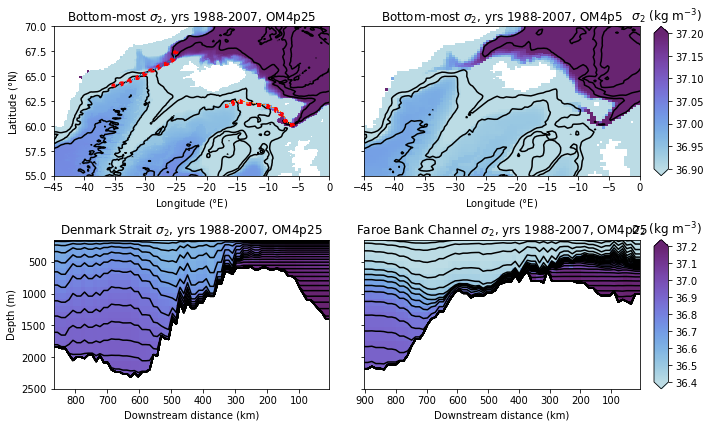

In [12]:
plt.figure(figsize=(10,6))

cm = truncate_colormap( cmocean.cm.dense, minval=.1, maxval=0.8)

plt.subplot(2,2,1)
depth=om4p25static.variables['deptho'][:]
qt = om4p25.variables['thetao'][0,:,:,:]
qs = om4p25.variables['so'][0,:,:,:]
qp25 = dens_wright_eos(qt,qs,2e7)-1000
plt.pcolormesh(xq,yq, get_last_real_value( qp25 ), cmap=cm); 
plt.xlabel('Longitude ($\degree$E)');
plt.ylabel('Latitude ($\degree$N)')
plt.title('Bottom-most $\sigma_2$, yrs 1988-2007, OM4p25')
#plt.clim(36.5, 37.3)
plt.clim(36.9,37.2)
#cb = plt.colorbar(); cb.set_label('$\sigma_2$ (kg/m$^3$)')
plt.contour(xh,yh,depth[:],[0,1000,2000,3000,4000,5000],colors='black');
plt.xlim(-45,0.); plt.ylim(55, 70);
# plt.plot( numpy.array(points_DS).T[0], numpy.array(points_DS).T[1], 'mo', )
T_DS.plot_line('r:',linewidth=4)
# plt.plot( numpy.array(points_FBC).T[0], numpy.array(points_FBC).T[1], 'mo', )
T_FBC.plot_line('r:',linewidth=4)

ax2 = plt.subplot(2,2,2)
depth=om4p5static.variables['deptho'][:]
qt = om4p5.variables['thetao'][0,:,:,:]
qs = om4p5.variables['so'][0,:,:,:]
qp5 = dens_wright_eos(qt,qs,2e7)-1000
im2 = plt.pcolormesh(xqp5,yqp5, get_last_real_value( qp5 ), cmap=cm); # im is recorded for the colorbar later
plt.xlabel('Longitude ($\degree$E)');
#plt.ylabel('Latitude ($\degree$N)'); # No label to make space
plt.gca().set_yticklabels(''); # Remove labels to make space
plt.title('Bottom-most $\sigma_2$, yrs 1988-2007, OM4p5')
#plt.clim(36.5, 37.3)
plt.clim(36.9,37.2)
# cb = plt.colorbar(); cb.set_label('$\sigma_2$ (kg/m$^3$)')
plt.contour(xhp5,yhp5,depth[:],[0,1000,2000,3000,4000,5000],colors='black');
plt.xlim(-45,0.); plt.ylim(55, 70);

plt.subplot(2,2,3)
zl = -om4p25.variables['z_l'][:] # 1-D nominal depths of cell-centers for z-output
depth=om4p25static.variables['deptho']
zl_DS = numpy.broadcast_to(zl, (T_DS.hdist.shape[0],zl.shape[0]) ).T # Creates a 2d array of nominal depths
zl_DS = numpy.maximum( zl_DS, -T_DS.get_h(depth) ) # Fixes nominal positions for partial cells
h_on_sect = T_DS.get_h(h[0])
z_on_sect = numpy.zeros((h_on_sect.shape[0]+1,h_on_sect.shape[1]))
z_on_sect[-1,:] = -T_DS.get_h(depth) # Bottom
for k in range(h_on_sect.shape[0]-1,0,-1):
    z_on_sect[k,:] = z_on_sect[k+1,:] + h_on_sect[k,:]
plt.pcolormesh( T_DS.hdist/1e3, -zl_DS, T_DS.get_h(qp25), cmap=cm )
plt.plot( T_DS.hdist/1e3, -z_on_sect.T, 'k' );
plt.ylim(2500,150);
plt.xlabel('Downstream distance (km)');
plt.ylabel('Depth (m)')
plt.title('Denmark Strait $\sigma_2$, yrs 1988-2007, OM4p25')
#plt.clim(36.3, 37.2)
plt.clim(36.4, 37.2)
plt.gca().invert_xaxis()

ax = plt.subplot(2,2,4)
zl_FBC = numpy.broadcast_to(zl, (T_FBC.hdist.shape[0],zl.shape[0]) ).T # Creates a 2d array of nominal depths
zl_FBC = numpy.maximum( zl_FBC, -T_FBC.get_h(depth) ) # Fixes nominal positions for partial cells
h_on_sect = T_FBC.get_h(h[0])
z_on_sect = numpy.zeros((h_on_sect.shape[0]+1,h_on_sect.shape[1]))
z_on_sect[-1,:] = -T_FBC.get_h(depth) # Bottom
for k in range(h_on_sect.shape[0]-1,0,-1):
    z_on_sect[k,:] = z_on_sect[k+1,:] + h_on_sect[k,:]
im = plt.pcolormesh( T_FBC.hdist/1e3, -zl_FBC, T_FBC.get_h(qp25), cmap=cm )
plt.plot( T_FBC.hdist/1e3, -z_on_sect.T, 'k' );
plt.ylim(2500,150);
plt.xlabel('Downstream distance (km)');
#plt.ylabel('Depth (m)'); # No label to make space
plt.gca().set_yticklabels(''); # Remove labels to make space
plt.title('Faroe Bank Channel $\sigma_2$, yrs 1988-2007, OM4p25')
#plt.clim(36.3, 37.2)
plt.clim(36.4, 37.2)
plt.gca().invert_xaxis()

plt.tight_layout(rect=[0,0,.935,1]); # Leave space on right for colorbar

# Add colorbar
bb = ax2.get_position();
cbar_ax = plt.gcf().add_axes([bb.x1+.02,bb.y0,.02,bb.y1-bb.y0]);
cb = plt.gcf().colorbar(im2, cax=cbar_ax, extend='both');
cb.ax.set_title('   $\sigma_2$ (kg m$^{-3}$)'); # Label above colorbar

# Add colorbar
bb = ax.get_position();
cbar_ax = plt.gcf().add_axes([bb.x1+.02,bb.y0,.02,bb.y1-bb.y0]);
cb = plt.gcf().colorbar(im, cax=cbar_ax, ticks=numpy.arange(36.4,37.3,.1), extend='both');
cb.ax.set_title('   $\sigma_2$ (kg m$^{-3}$)'); # Label above colorbar

plt.savefig('overflows-natl.png')

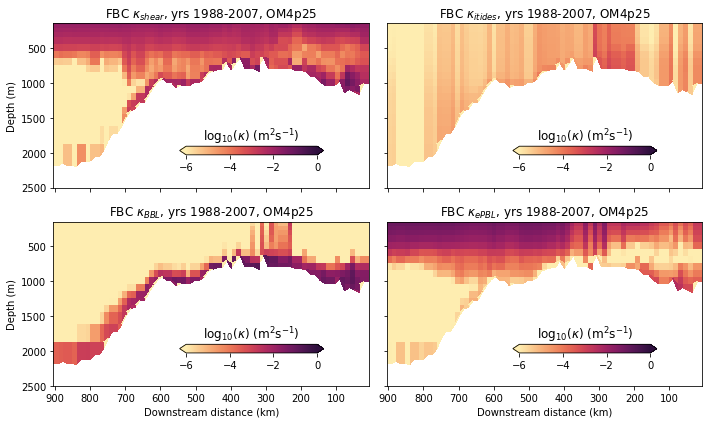

In [13]:
plt.figure(figsize=(10,6))

cmt = cmocean.cm.matter

zi = -om4p25.variables['z_i'][:] # 1-D nominal depths of w-points for z-output
Kdshear = om4p25.variables['Kd_shear'][0,:,:,:] +1e-15
Kdtides = om4p25.variables['Kd_itides'][0,:,:,:] +1e-15
KdBBL = om4p25.variables['Kd_BBL'][0,:,:,:] +1e-15
Kd_ePBL = om4p25.variables['Kd_ePBL'][0,:,:,:] +1e-15
depth=om4p25static.variables['deptho']
zi_FBC = numpy.broadcast_to(zi, (T_FBC.hdist.shape[0],zi.shape[0]) ).T # Creates a 2d array of nominal depths
zi_FBC = numpy.maximum( zi_FBC, -T_FBC.get_h(depth) ) # Fixes nominal positions for partial cells

ax1 = plt.subplot(2,2,1)
im1 = plt.pcolormesh( T_FBC.hdist/1e3, -zi_FBC, numpy.log10(T_FBC.get_h(Kdshear)), cmap=cmt )
plt.ylim(2500,150);
plt.gca().set_xticklabels(''); # Remove labels to make space
plt.ylabel('Depth (m)');
plt.title('FBC $\kappa_{shear}$, yrs 1988-2007, OM4p25')
plt.clim(-6,0)
plt.gca().invert_xaxis()

ax2 = plt.subplot(2,2,2)
im2 = plt.pcolormesh( T_FBC.hdist/1e3, -zi_FBC, numpy.log10(T_FBC.get_h(Kdtides)), cmap=cmt )
plt.ylim(2500,150);
plt.gca().set_xticklabels(''); # Remove labels to make space
plt.gca().set_yticklabels(''); # Remove labels to make space
plt.title('FBC $\kappa_{itides}$, yrs 1988-2007, OM4p25')
plt.clim(-6,0)
plt.gca().invert_xaxis()

ax3 = plt.subplot(2,2,3)
im3 = plt.pcolormesh( T_FBC.hdist/1e3, -zi_FBC, numpy.log10(T_FBC.get_h(KdBBL)), cmap=cmt)
plt.ylim(2500,150);
plt.xlabel('Downstream distance (km)');
plt.ylabel('Depth (m)');
plt.title('FBC $\kappa_{BBL}$, yrs 1988-2007, OM4p25')
plt.clim(-6,0)
plt.gca().invert_xaxis()

ax4 = plt.subplot(2,2,4)
im4 = plt.pcolormesh( T_FBC.hdist/1e3, -zi_FBC, numpy.log10(T_FBC.get_h(Kd_ePBL)), cmap=cmt )
plt.ylim(2500,150);
plt.xlabel('Downstream distance (km)');
plt.gca().set_yticklabels(''); # Remove labels to make space
plt.title('FBC $\kappa_{ePBL}$, yrs 1988-2007, OM4p25')
plt.clim(-6,0)
plt.gca().invert_xaxis()

plt.tight_layout()

# Add colorbars
bbl = ax1.get_position();
ax = plt.gcf().add_axes(((bbl.x0*3+2*bbl.x1)/5,(bbl.y0*4+bbl.y1)/5,.2,.02))
cb = plt.gcf().colorbar(im1, cax=ax, extend='both', orientation='horizontal');
cb.ax.set_title('log$_{10}(\kappa)$ (m$^2$s$^{-1}$)')

bbl = ax2.get_position();
ax = plt.gcf().add_axes(((bbl.x0*3+2*bbl.x1)/5,(bbl.y0*4+bbl.y1)/5,.2,.02))
cb = plt.gcf().colorbar(im2, cax=ax, extend='both', orientation='horizontal');
cb.ax.set_title('log$_{10}(\kappa)$ (m$^2$s$^{-1}$)')

bbl = ax3.get_position();
ax = plt.gcf().add_axes(((bbl.x0*3+2*bbl.x1)/5,(bbl.y0*4+bbl.y1)/5,.2,.02))
cb = plt.gcf().colorbar(im3, cax=ax, extend='both', orientation='horizontal');
cb.ax.set_title('log$_{10}(\kappa)$ (m$^2$s$^{-1}$)')

bbl = ax4.get_position();
ax = plt.gcf().add_axes(((bbl.x0*3+2*bbl.x1)/5,(bbl.y0*4+bbl.y1)/5,.2,.02))
cb = plt.gcf().colorbar(im4, cax=ax, extend='both', orientation='horizontal');
cb.ax.set_title('log$_{10}(\kappa)$ (m$^2$s$^{-1}$)')

plt.savefig('overflows-diffusivity.png')

In [14]:
# Mediterranean Outlow track
points_MO = ((-5.0, 35.8),(-9.0, 35.8))
T_MO = Track(xq, yq, xh, yh, points_MO )

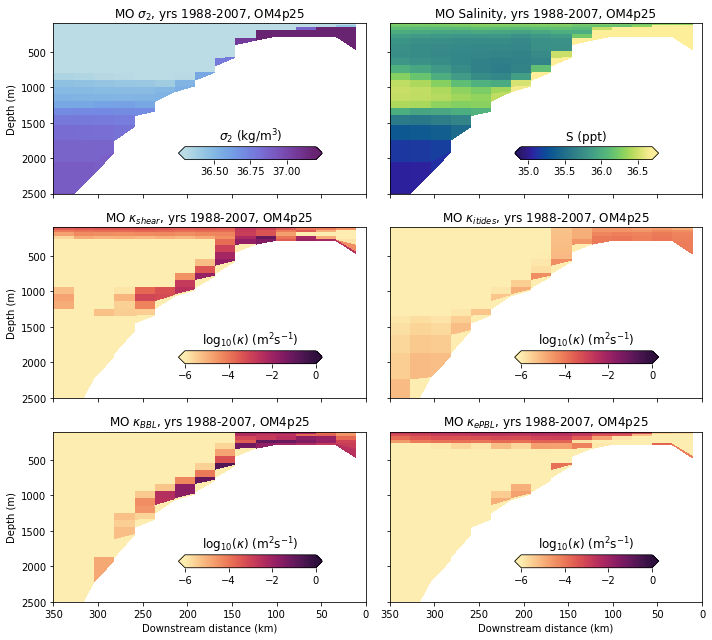

In [15]:
plt.figure(figsize=(10,9))

qt = om4p25.variables['thetao'][0,:,:,:]
qs = om4p25.variables['so'][0,:,:,:]
qp25 = dens_wright_eos(qt,qs,2e7)-1000
zl = -om4p25.variables['z_l'][:] # 1-D nominal depths of cell-centers for z-output
depth = om4p25static.variables['deptho']
zl_MO = numpy.broadcast_to(zl, (T_MO.hdist.shape[0],zl.shape[0]) ).T # Creates a 2d array of nominal depths
zl_MO = numpy.maximum( zl_MO, -T_MO.get_h(depth) ) # Fixes nominal positions for partial cells
zi_MO = numpy.broadcast_to(zi, (T_MO.hdist.shape[0],zi.shape[0]) ).T # Creates a 2d array of nominal depths
zi_MO = numpy.maximum( zi_MO, -T_MO.get_h(depth) ) # Fixes nominal positions for partial cells
h_on_sect = T_MO.get_h(h[0])
z_on_sect = numpy.zeros((h_on_sect.shape[0]+1,h_on_sect.shape[1]))
z_on_sect[-1,:] = -T_MO.get_h(depth) # Bottom
for k in range(h_on_sect.shape[0]-1,0,-1):
    z_on_sect[k,:] = z_on_sect[k+1,:] + h_on_sect[k,:]

ax1 = plt.subplot(3,2,1)
im1=plt.pcolormesh( T_MO.hdist/1e3, -zl_MO, T_MO.get_h(qp25), cmap=cm )
plt.plot( -T_MO.hdist/1e3, -z_on_sect.T, 'k' );
plt.ylim(2500,100);
plt.xlim(350,0)
plt.gca().set_xticklabels(''); # Remove labels to make space
plt.ylabel('Depth (m)')
plt.title('MO $\sigma_2$, yrs 1988-2007, OM4p25')
plt.clim(36.3, 37.2)

ax2 = plt.subplot(3,2,2)
im2 = plt.pcolormesh( T_MO.hdist/1e3, -zl_MO, T_MO.get_h(qs), cmap=cmocean.cm.haline )
plt.plot( -T_MO.hdist/1e3, -z_on_sect.T, 'k' );
plt.ylim(2500,100);
plt.xlim(350,0)
plt.gca().set_xticklabels(''); # Remove labels to make space
plt.gca().set_yticklabels(''); # Remove labels to make space
plt.title('MO Salinity, yrs 1988-2007, OM4p25')
plt.clim(34.9, 36.7);

ax3 = plt.subplot(3,2,3)
im3 = plt.pcolormesh( T_MO.hdist/1e3, -zi_MO, numpy.log10(T_MO.get_h(Kdshear)), cmap=cmt )
plt.xlim(350,0)
plt.ylim(2500,100);
plt.gca().set_xticklabels(''); # Remove labels to make space
plt.ylabel('Depth (m)')
plt.title('MO $\kappa_{shear}$, yrs 1988-2007, OM4p25')
plt.clim(-6,0)

ax4 = plt.subplot(3,2,4)
im4 = plt.pcolormesh( T_MO.hdist/1e3, -zi_MO, numpy.log10(T_MO.get_h(Kdtides)), cmap=cmt )
plt.xlim(350,0)
plt.ylim(2500,100);
plt.gca().set_xticklabels(''); # Remove labels to make space
plt.gca().set_yticklabels(''); # Remove labels to make space
plt.title('MO $\kappa_{itides}$, yrs 1988-2007, OM4p25')
plt.clim(-6,0)

ax5 = plt.subplot(3,2,5)
im5 = plt.pcolormesh( T_MO.hdist/1e3, -zi_MO, numpy.log10(T_MO.get_h(KdBBL)), cmap=cmt )
plt.xlim(350,0)
plt.ylim(2500,100);
plt.ylabel('Depth (m)')
plt.xlabel('Downstream distance (km)');
plt.title('MO $\kappa_{BBL}$, yrs 1988-2007, OM4p25')
plt.clim(-6,0)

ax6 = plt.subplot(3,2,6)
im6 = plt.pcolormesh( T_MO.hdist/1e3, -zi_MO, numpy.log10(T_MO.get_h(Kd_ePBL)), cmap=cmt )
plt.xlim(350,0)
plt.ylim(2500,100);
plt.xlabel('Downstream distance (km)');
plt.gca().set_yticklabels(''); # Remove labels to make space
plt.title('MO $\kappa_{ePBL}$, yrs 1988-2007, OM4p25')
plt.clim(-6,0)

plt.tight_layout()

# Add colorbars
bbl = ax1.get_position();
ax = plt.gcf().add_axes(((bbl.x0*3+2*bbl.x1)/5,(bbl.y0*4+bbl.y1)/5,.2,.02))
cb = plt.colorbar(im1,cax=ax,extend='both',orientation='horizontal')
cb.ax.set_title('$\sigma_2$ (kg/m$^3$)'); # Label above colorbar

bbl = ax2.get_position();
ax = plt.gcf().add_axes(((bbl.x0*3+2*bbl.x1)/5,(bbl.y0*4+bbl.y1)/5,.2,.02))
cb = plt.colorbar(im2,cax=ax,extend='both',orientation='horizontal')
cb.ax.set_title('S (ppt)'); # Label above colorbar

bbl = ax3.get_position();
ax = plt.gcf().add_axes(((bbl.x0*3+2*bbl.x1)/5,(bbl.y0*4+bbl.y1)/5,.2,.02))
cb = plt.colorbar(im3,cax=ax,extend='both',orientation='horizontal')
cb.ax.set_title('log$_{10}(\kappa)$ (m$^2$s$^{-1}$)')

bbl = ax4.get_position();
ax = plt.gcf().add_axes(((bbl.x0*3+2*bbl.x1)/5,(bbl.y0*4+bbl.y1)/5,.2,.02))
cb = plt.colorbar(im4,cax=ax,extend='both',orientation='horizontal')
cb.ax.set_title('log$_{10}(\kappa)$ (m$^2$s$^{-1}$)')

bbl = ax5.get_position();
ax = plt.gcf().add_axes(((bbl.x0*3+2*bbl.x1)/5,(bbl.y0*4+bbl.y1)/5,.2,.02))
cb = plt.colorbar(im5,cax=ax,extend='both',orientation='horizontal')
cb.ax.set_title('log$_{10}(\kappa)$ (m$^2$s$^{-1}$)')

bbl = ax6.get_position();
ax = plt.gcf().add_axes(((bbl.x0*3+2*bbl.x1)/5,(bbl.y0*4+bbl.y1)/5,.2,.02))
cb = plt.colorbar(im6,cax=ax,extend='both',orientation='horizontal')
cb.ax.set_title('log$_{10}(\kappa)$ (m$^2$s$^{-1}$)')

plt.savefig('overflows-med-density-salt.png')